In [ ]:
!pip3 install seaborn --quiet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

In [2]:
@dataclass(frozen=True)
class Constants:
    k: float = 1.38e-23   # Boltzmann constant (J/K)
    q: float = 1.602176634e-19
    T_r: float = 300
    n: float = 1.2
    k_mu: float = 1.5
    k_vt: float = 1e-3 # Typical value for threshold voltage temperature dependence (in V/K)

    @property
    def vt_r(self):
        return self.k * self.T_r / self.q

    @property
    def vt_nom(self):
        return self.k * self.T / self.q
    
weight_levels = [0.020000, 0.05327272727272728, 0.08654545454545455, 0.11981818181818182, 0.15309090909090908, 0.18636363636363637, 0.21963636363636363, 0.2529090909090909, 0.2861818181818182, 0.3194545454545455, 0.3527272727272728, 0.386000]
threshold_values = [110, 75, 55, 51, 43, 35, 23, 18, 14, 10, 7, 0]
parameters = ['W', 'L', 'mu_n', 'Cox', 'Vth', 'T', 'VDS']

In [3]:
consts = Constants()
weight_index = len(weight_levels)-2  # Index for the weight level to be used (0-11)

Vds_nom = 0.8  # Nominal VDS value (in Volts)
Id_nom = weight_levels[weight_index ]  # Nominal Id value (in Amps)
Vth_nom = 0.15 + threshold_values[weight_index ]*1e-3 # Nominal threshold voltage (V)

T = 300        # Temperature in Kelvin
vt_r = consts.k * consts.T_r / consts.q  # Thermal voltage at room temperature
vt_nom = consts.k * T / consts.q  # Thermal voltage

Mt1 = 243/300
Mt2 = 398/300

Mt1 = 260/300
Mt2 = 340/300

Mt1 = 260/300
Mt2 = 340/300

# Function to calculate new Id based on the given formulas
def calculate_new_Id_table(parameter, M, Id_nom, Vth_nom):
    if parameter == 'W':
        return M * Id_nom  # ID' = M * ID
    elif parameter == 'L':
        return (1 / M) * Id_nom  # ID' = (1/M) * ID
    elif parameter == 'mu_n':
        return M * Id_nom  # ID' = M * ID
    elif parameter == 'Cox':
        return M * Id_nom  # ID' = M * ID
    elif parameter == 'Vth':
        return Id_nom * np.exp(-((M - 1) * Vth_nom) / (consts.n * vt_nom))  # ID' = ID * exp(-((M - 1) * Vth) / (n * vt))
    elif parameter == 'T':  # Temperature variation case
        T = M * consts.T_r  # M represents the ratio of T/T_r
        vt_T = consts.k * T / consts.q  # Thermal voltage at new temperature T
        return Id_nom * (consts.T_r / T) ** (consts.k_mu + 2) * np.exp((consts.k_vt * (T - consts.T_r)) / (consts.n * vt_T))  # ID formula with temperature variation  
    elif parameter == 'VDS':
        if Vds_nom is None or vt_nom is None:
            raise ValueError("Vds_nom and vt_nom must be provided for VDS variation")
        numerator = 1 - np.exp(-M * Vds_nom / vt_nom)
        denominator = 1 - np.exp(-Vds_nom / vt_nom)
        return Id_nom * (numerator / denominator)
    else:
        raise ValueError("Invalid parameter name")

def compute_Id_range_table(parameter, M_min, M_max, Id_nom, Vth_nom, num_samples=1000, distribution="uniform"):
    if distribution == "uniform":
        M_values = np.random.uniform(M_min, M_max, num_samples)
    elif distribution == "normal":
        mean_M = (M_max + M_min) / 2
        std_M = (M_max - M_min) / 4  # Roughly within ±2σ range
        M_values = np.random.normal(mean_M, std_M, num_samples)
        M_values = np.clip(M_values, M_min, M_max)  # Ensure values remain in range
        #M_values = M_values[(M_values >= M_min) & (M_values <= M_max)]
    else:
        raise ValueError("Invalid distribution type")

    Id_values = np.array([calculate_new_Id_table(parameter, M, Id_nom, Vth_nom) for M in M_values])

    return M_values, Id_values

def compute_Id_variations(Id_nom, Vth_nom, num_samples=1000):
    all_Id_values = []
    max_shifts = {}

    for param in parameters:
        if param == "T":
            M_values = np.linspace(Mt1, Mt2, num_samples)  # Temperature from -30°C to 125°C (converted to Kelvin)
        elif param == "Vth":
            M_values = np.linspace(.97, 1.03, num_samples)  # Range from 1 to 1.3
        else:
            M_values = np.linspace(0.95, 1.05, num_samples)  # Range from 0.9 to 1.1

        Id_values = np.array([calculate_new_Id_table(param, M, Id_nom, Vth_nom) for M in M_values])

        # Find the value with the greatest shift from Id_nom
        max_shift_idx = np.argmax(np.abs(Id_values - Id_nom))
        max_shifts[param] = (M_values[max_shift_idx], Id_values[max_shift_idx])

        # Add all values (except the max shift) to the combined list
        all_Id_values.extend(np.delete(Id_values, max_shift_idx))

    return all_Id_values, max_shifts

Minimum Id value: 0.3477159419876547
Maximum Id value: 0.8117508266792196
Percentage deviation from min: 10.85%
Percentage deviation from max: 120.70%


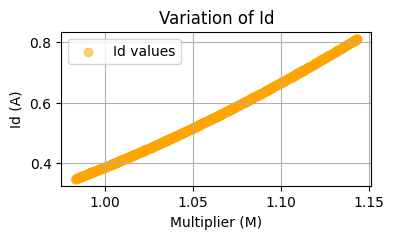

In [ ]:
Mt1 = 295/300
Mt2 = 343/300

Id_nom1 = 0.386000
M_values, Id_values = compute_Id_range_table("T", Mt1, Mt2, Id_nom1, Vth_nom, num_samples=1000, distribution="uniform") #temperature

Id_min = np.min(Id_values)
Id_max = np.max(Id_values)
deviation_min = (abs(Id_nom1 - Id_min) / Id_nom) * 100
deviation_max = (abs(Id_nom1 - Id_max) / Id_nom) * 100

print(f"Minimum Id value: {Id_min}")
print(f"Maximum Id value: {Id_max}")
print(f"Percentage deviation from min: {deviation_min:.2f}%")
print(f"Percentage deviation from max: {deviation_max:.2f}%")
plt.figure(figsize=(4, 2))
plt.scatter(M_values, Id_values, alpha=0.5, color='orange', label="Id values")
plt.xlabel("Multiplier (M)")
plt.ylabel("Id (A)")
plt.title("Variation of Id")
plt.legend()
plt.grid(True)
plt.show()

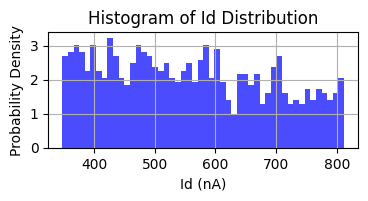

In [5]:
import matplotlib.ticker as ticker
plt.figure(figsize=(4, 1.5))
plt.hist(Id_values, bins=50, alpha=0.7, color='blue', density=True)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x*1000:.0f}"))
plt.xlabel("Id (nA)")
plt.ylabel("Probability Density")
plt.title(f"Histogram of Id Distribution")
plt.grid(True)
plt.show()


Maximum Shift in Id for Each Parameter:
W: M = 0.950, Id = 3.351e-01
L: M = 0.950, Id = 3.713e-01
mu_n: M = 0.950, Id = 3.351e-01
Cox: M = 0.950, Id = 3.351e-01
Vth: M = 0.970, Id = 4.106e-01
T: M = 1.133, Id = 7.104e-01
VDS: M = 0.950, Id = 3.527e-01


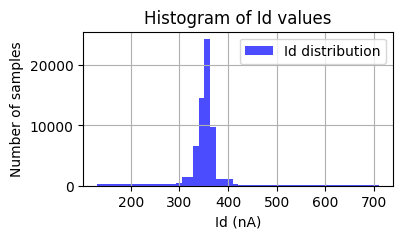

In [16]:
all_Id_values, max_shifts = compute_Id_variations(Id_nom, Vth_nom, num_samples=10000)

# Print the maximum shift values
print("\nMaximum Shift in Id for Each Parameter:")
for param, (M_value, Id_value) in max_shifts.items():
    print(f"{param}: M = {M_value:.3f}, Id = {Id_value:.3e}")

plt.figure(figsize=(4, 2))
plt.hist(all_Id_values, bins=50, alpha=0.7, color='blue', density=False, label="Id distribution")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x*1000:.0f}"))
plt.xlabel("Id (nA)")
plt.ylabel("Number of samples")
plt.title("Histogram of Id values")
plt.legend()
plt.grid(True)
plt.show()